<a href="https://colab.research.google.com/github/kazim-glitch/Deep-learning/blob/main/Image_Classification_of_Cifar10_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ')
else:
    print('CUDA is available!  Training on GPU')

CUDA is available!  Training on GPU


In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
validation_data = 0.2

#images to vectors 

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                
])

traindata = datasets.CIFAR10('data',train=True,download=True,transform=transform)

testdata = datasets.CIFAR10('data',train=False,download=True,transform=transform)



Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
number_of_training= len(traindata)
index= list(range(number_of_training))
np.random.shuffle(index)
split = int(np.floor(validation_data*number_of_training))

train_index,validation_index = index[split:],index[:split]

train_sample = SubsetRandomSampler(train_index)

valid_sample = SubsetRandomSampler(validation_index)

train_loading= torch.utils.data.DataLoader(traindata,batch_size=20,sampler=train_sample)

valid_loading = torch.utils.data.DataLoader(traindata,batch_size=20,sampler=valid_sample)

test_loading = torch.utils.data.DataLoader(testdata,batch_size=20)


classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0)))

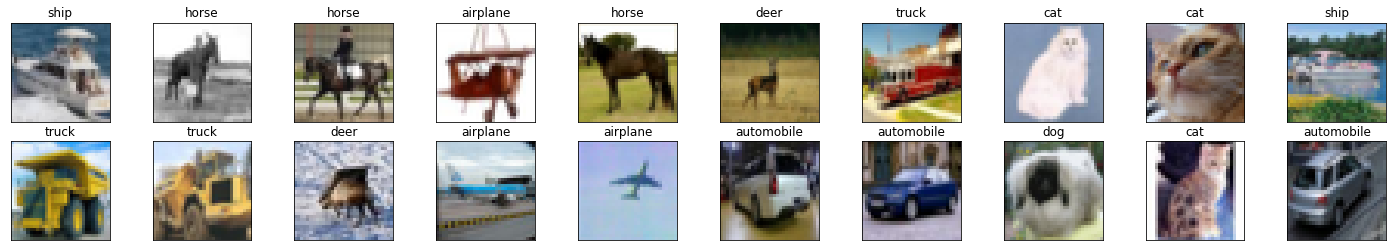

In [ ]:
dataiter = iter(train_loading)
images, labels = dataiter.next()
images = images.numpy() 

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

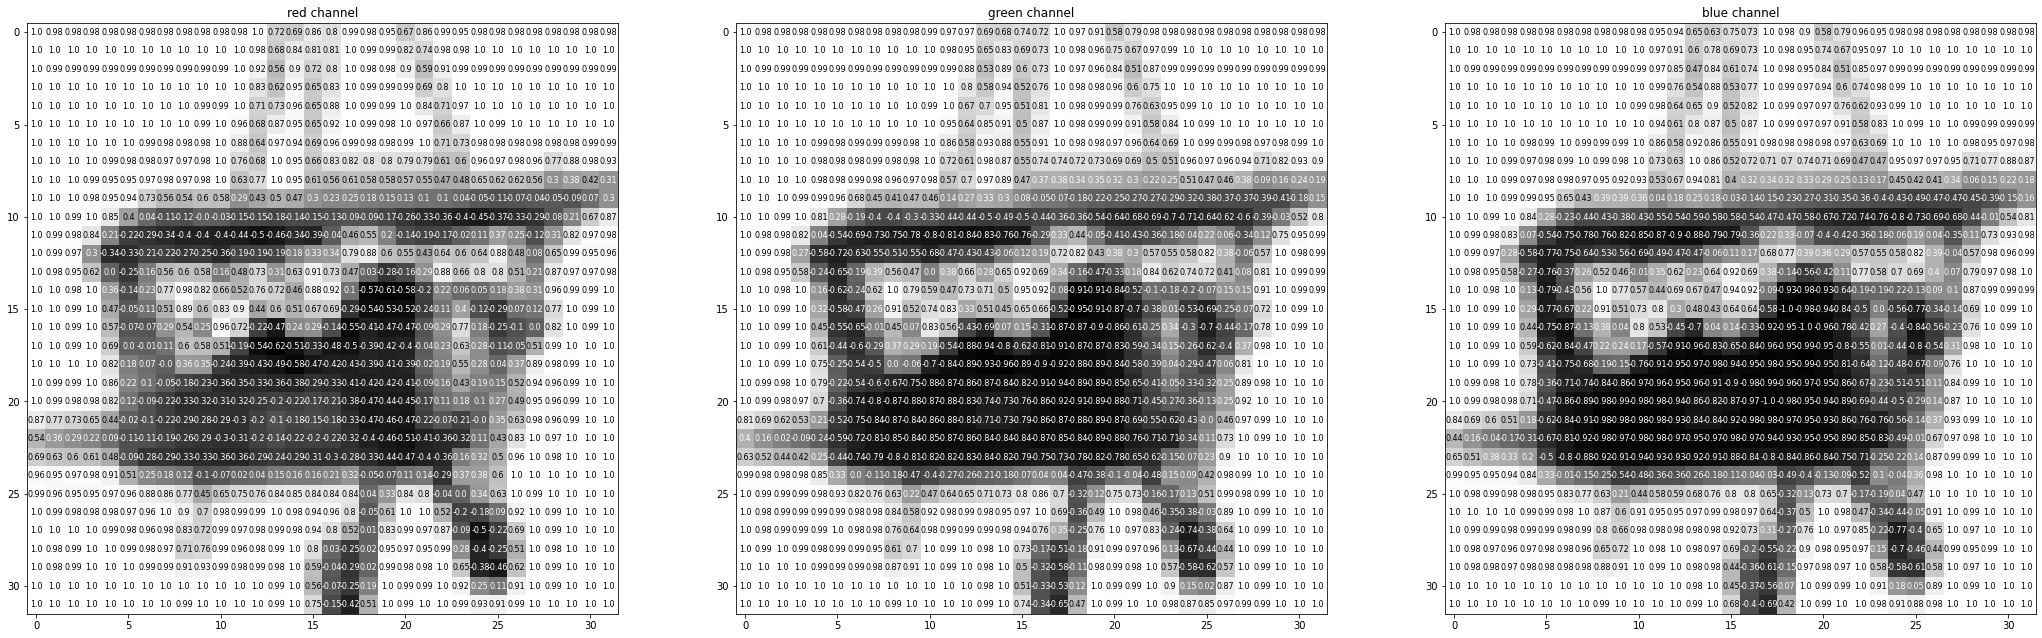

In [ ]:
rgb_image = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_image.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_image[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 4 * 4, 500)

        self.fc2 = nn.Linear(500, 10)

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
      
        x  = self.pool(F.relu(self.conv1(x)))
     
        x = self.pool(F.relu(self.conv2(x)))
     
        x = self.pool(F.relu(self.conv3(x)))
     
        x = x.view(-1, 64 * 4 * 4)
     
     
        x = self.dropout(x)
     
        x = F.relu(self.fc1(x))
     
     
        x = self.dropout(x)
     
        x = self.fc2(x)
     
        return x


model = Network()

print(model)

if train_on_gpu:
    model.cuda()

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05)

In [ ]:
epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, epochs+1):

    
    train_loss = 0.0
    valid_loss = 0.0
    

    model.train()
    for data, target in train_loading:
        if train_on_gpu:
          data, target = data.cuda(), target.cuda()
          
          optimizer.zero_grad()

          output = model(data)

          loss = criterion(output, target)

          loss.backward()

          optimizer.step()

          train_loss += loss.item()*data.size(0)
        
 
    model.eval()
    for data, target in valid_loading:

        if train_on_gpu:
          data, target = data.cuda(), target.cuda()
          
          output = model(data)

          loss = criterion(output, target)

          valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loading.sampler)
    valid_loss = valid_loss/len(valid_loading.sampler)
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.758309 	Validation Loss: 1.427805
Validation loss decreased (inf --> 1.427805).  Saving model ...
Epoch: 2 	Training Loss: 1.302572 	Validation Loss: 1.159155
Validation loss decreased (1.427805 --> 1.159155).  Saving model ...
Epoch: 3 	Training Loss: 1.098040 	Validation Loss: 0.986029
Validation loss decreased (1.159155 --> 0.986029).  Saving model ...
Epoch: 4 	Training Loss: 0.968018 	Validation Loss: 0.879858
Validation loss decreased (0.986029 --> 0.879858).  Saving model ...
Epoch: 5 	Training Loss: 0.884284 	Validation Loss: 0.827886
Validation loss decreased (0.879858 --> 0.827886).  Saving model ...
Epoch: 6 	Training Loss: 0.812881 	Validation Loss: 0.803077
Validation loss decreased (0.827886 --> 0.803077).  Saving model ...
Epoch: 7 	Training Loss: 0.747140 	Validation Loss: 0.799518
Validation loss decreased (0.803077 --> 0.799518).  Saving model ...
Epoch: 8 	Training Loss: 0.700070 	Validation Loss: 0.784886
Validation loss decreased (0.79951

In [ ]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [ ]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loading:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(20):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loading.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.794554

Test Accuracy of airplane: 76% (763/1000)
Test Accuracy of automobile: 89% (894/1000)
Test Accuracy of  bird: 53% (536/1000)
Test Accuracy of   cat: 47% (479/1000)
Test Accuracy of  deer: 67% (679/1000)
Test Accuracy of   dog: 70% (701/1000)
Test Accuracy of  frog: 80% (808/1000)
Test Accuracy of horse: 77% (779/1000)
Test Accuracy of  ship: 84% (844/1000)
Test Accuracy of truck: 78% (788/1000)

Test Accuracy (Overall): 72% (7271/10000)


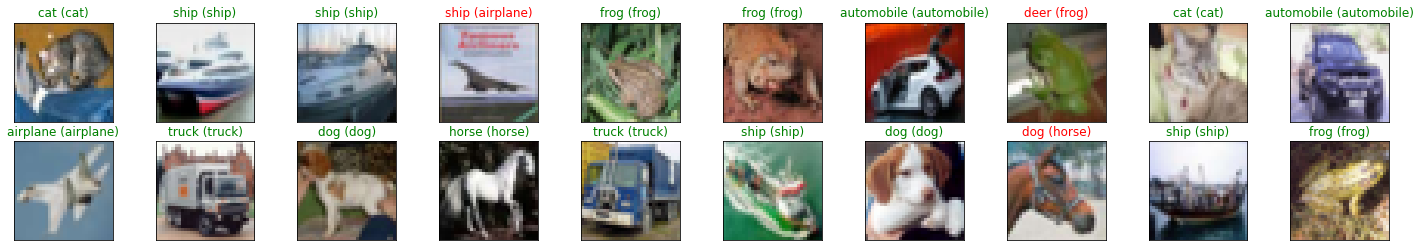

In [ ]:
dataiter = iter(test_loading)
images, labels = dataiter.next()
images.numpy()

if train_on_gpu:
    images = images.cuda()

output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))